# Sentiment analysis using neural networks

One of the common uses for binary classification in machine learning is analyzing text for sentiment — specifically, assigning a text string a score from 0 to 1, where 0 represents negative sentiment and 1 represents positive sentiment. A restaurant review such as "Best meal I've ever had and awesome service, too!" might score 0.9 or higher, while a statement such as "Long lines and poor customer service" would score closer to 0. Marketing departments sometimes use sentiment-anlysis models to monitor social-media services for feedback so they can respond quickly if, for example, comments regarding their company suddenly turn negative.

To train a neural network to perform sentiment analysis, you need a dataset containing text strings labeled with 0s (for negative sentiment) and 1s (for positive sentiment). Several such datasets are available in the public domain. We will use one containing 50,000 movie reviews, each labeled with a 0 or 1. Once the network is trained, scoring a text string for sentiment is a simple matter of passing it to the network and asking for the probability that the predicted label is 1. A probability of 80% means the sentiment score is 0.8 and that the text is very positive.

![](Images/sentiment.jpg)

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with raw text, we'll use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the training text. And because Keras doesn't include support for removing stop words as Scikit-learn does, we'll use the [Natural Language Tookit](https://www.nltk.org/) (NLTK) to remove stop words such as "the" and "a." Then we'll split the data for training and testing.

In [3]:
import pandas as pd

df = pd.read_csv('Data/reviews.csv', encoding="ISO-8859-1")
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


Find out how many rows the dataset contains and confirm that there are no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Remove duplicate rows and check for balance.

In [5]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  Once again Mr. Costner has dragged out a movie...   
1          24884  24884  I went and saw this movie last night after bei...   

                
          freq  
Sentiment       
0            1  
1            1

Create a feature column *x* containing the text in the "Text" column with stopwords removed, and a label column *y*.

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK data is downloaded
nltk.download('punkt_tab')
nltk.download('stopwords')

def remove_stop_words(text):
    # Tokenize the text and filter out stop words
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the remove_stop_words function to each row in the 'Text' column
x = df['Text'].apply(remove_stop_words)
y = df['Sentiment']


[nltk_data] Downloading package punkt_tab to /home/user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Use Keras's [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize the cleaned text, and then created padded sequences holding up to 500 tokens each.

In [12]:
import tensorflow as tf

max_words = 20000
max_length = 200

# Initialize the Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(x)

# Pad the sequences to ensure they all have the same length
x = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)

2024-08-28 14:26:49.938748: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 14:26:49.942493: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 14:26:49.954259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 14:26:49.973698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 14:26:49.984259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 14:26:50.000155: I tensorflow/core/platform/cpu_feature_gu

## Train a neural network

Create a neural network containing an [Embedding](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [Dense](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [13]:
import tensorflow as tf

# Define the model
model = tf.keras.Sequential() 
model.add(tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length)) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Print the model summary
model.summary()


/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-08-28 14:27:03.791004: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the network and capture the training history returned by `fit`.

In [14]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=250)

Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7150 - loss: 0.5264 - val_accuracy: 0.8000 - val_loss: 0.4851
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9465 - loss: 0.1461 - val_accuracy: 0.7483 - val_loss: 0.6799
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9908 - loss: 0.0410 - val_accuracy: 0.7459 - val_loss: 0.8673
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9988 - loss: 0.0082 - val_accuracy: 0.7507 - val_loss: 0.9924
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.7539 - val_loss: 1.0810


See how the training and validation accuracy evolved and make sure the network was trained for a sufficient number of epochs.

[]

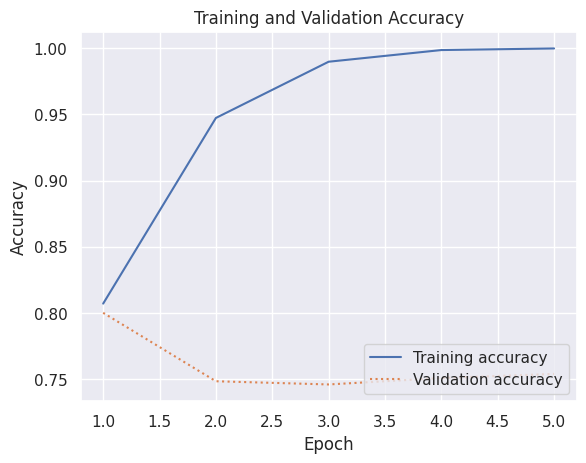

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to analyze text

Let's score a couple of reviews by tokenizing them and passing them to the model's `predict` method. Start with a positive review.

In [17]:
# Clean the input text
cleaned_text = remove_stop_words('Excellent food and fantastic service!')

# Convert the cleaned text to a sequence of integers
sequence = tokenizer.texts_to_sequences([cleaned_text])

# Pad the sequence to ensure it matches the model's input length
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length)

# Make a prediction using the trained model
prediction = model.predict(padded_sequence)[0][0]

# Output the prediction result
prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


0.9578259

And then a negative review.

In [18]:
# Clean the input text
cleaned_text = remove_stop_words('The long lines and poor customer service really turned me off.')

# Convert the cleaned text to a sequence of integers
sequence = tokenizer.texts_to_sequences([cleaned_text])

# Pad the sequence to ensure it matches the model's input length
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_length)

# Make a prediction using the trained model
prediction = model.predict(padded_sequence)[0][0]

# Output the prediction result
prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


0.034792837

Do the sentiment scores output by the model seem accurate?